1.cnn

In [2]:
import numpy as np
from keras.models import Model
from keras.layers import Dense
from keras.layers import multiply
from keras.layers import Flatten
from keras.layers import Input
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Activation
from keras.optimizers import Adam

timestep = 60
np.random.seed(10)

num_class = 5
train_sample_per_class = 20
lambda_value = 1


trainData = np.load("trainData.npy")
trainlabel = np.load("trainLabel.npy")
# trainData = trainData[:, -timestep*2:]
# trainlabel = trainlabel[:, -timestep*2:]
trainData = trainData[:, :timestep*2]
trainlabel = trainlabel[:, :timestep*2]
trainlabel = trainlabel.astype(int)

trainmask = np.zeros((trainlabel.shape[0],256))

class_counter = np.zeros((num_class))
train_size = trainlabel.shape[0]
j = 0
for i in range(train_size):
    class_id = trainlabel[i,2] - 1
    if class_counter[class_id] < train_sample_per_class:
        trainmask[i, :] = 1
        j += 1
        class_counter[class_id] += 1
print("unmasked samples: ", str(np.sum(trainmask==1)/256))


valData = np.load("valData.npy")
valLabel = np.load("valLabel.npy")
# testData = testData[:, -timestep*2:]
# testLabel = testLabel[:, -timestep*2:]
valData = valData[:, :timestep*2]
valLabel = valLabel[:, :timestep*2]

valLabel = valLabel.astype(int)
valmask = np.ones((valLabel.shape[0], 256))
valmask[:,:]=1


testData = np.load("testData.npy")
testLabel = np.load("testLabel.npy")
# testData = testData[:, -timestep*2:]
# testLabel = testLabel[:, -timestep*2:]
testData = testData[:, :timestep*2]
testLabel = testLabel[:, :timestep*2]

testLabel = testLabel.astype(int)
testmask = np.ones((testLabel.shape[0], 256))
testmask[:,:]=1

for i in range(trainlabel.shape[0]):
    #Categorizing Bandwidth
    if trainlabel[i, 0] < 10000:
        trainlabel[i, 0] = 1
    elif trainlabel[i, 0] < 50000:
        trainlabel[i, 0] = 2
    elif trainlabel[i, 0] < 100000:
        trainlabel[i, 0] = 3
    elif trainlabel[i, 0] < 1000000:
        trainlabel[i, 0] = 4
    else:
        trainlabel[i, 0] = 5
    #Categorizing Duration
    if trainlabel[i, 1] < 10:
        trainlabel[i, 1] = 1
    elif trainlabel[i, 1] < 30:
        trainlabel[i, 1] = 2
    elif trainlabel[i, 1] < 60:
        trainlabel[i, 1] = 3
    else:
        trainlabel[i, 1] = 4

for i in range(valLabel.shape[0]):
    #Categorizing Bandwidth
    if valLabel[i, 0] < 10000:
        valLabel[i, 0] = 1
    elif valLabel[i, 0] < 50000:
        valLabel[i, 0] = 2
    elif valLabel[i, 0] < 100000:
        valLabel[i, 0] = 3
    elif valLabel[i, 0] < 1000000:
        valLabel[i, 0] = 4
    else:
        valLabel[i, 0] = 5
    #Categorizing Duration
    if valLabel[i, 1] < 10:
        valLabel[i, 1] = 1
    elif valLabel[i, 1] < 30:
        valLabel[i, 1] = 2
    elif valLabel[i, 1] < 60:
        valLabel[i, 1] = 3
    else:
        valLabel[i, 1] = 4


for i in range(testLabel.shape[0]):
    #Categorizing Bandwidth
    if testLabel[i, 0] < 10000:
        testLabel[i, 0] = 1
    elif testLabel[i, 0] < 50000:
        testLabel[i, 0] = 2
    elif testLabel[i, 0] < 100000:
        testLabel[i, 0] = 3
    elif testLabel[i, 0] < 1000000:
        testLabel[i, 0] = 4
    else:
        testLabel[i, 0] = 5
    #Categorizing Duration
    if testLabel[i, 1] < 10:
        testLabel[i, 1] = 1
    elif testLabel[i, 1] < 30:
        testLabel[i, 1] = 2
    elif testLabel[i, 1] < 60:
        testLabel[i, 1] = 3
    else:
        testLabel[i, 1] = 4


train_size = trainlabel.shape[0]
Y_train1 = np.zeros((train_size,5))
Y_train1[np.arange(train_size),trainlabel[:,0]-1] = 1
Y_train2 = np.zeros((train_size,4))
Y_train2[np.arange(train_size),trainlabel[:,1]-1] = 1
Y_train3 = np.zeros((train_size,5))
Y_train3[np.arange(train_size),trainlabel[:,2]-1] = 1

val_size = valLabel.shape[0]
Y_val1 = np.zeros((val_size,5))
Y_val1[np.arange(val_size),valLabel[:,0]-1] = 1
Y_val2 = np.zeros((val_size,4))
Y_val2[np.arange(val_size),valLabel[:,1]-1] = 1
Y_val3 = np.zeros((val_size,5))
Y_val3[np.arange(val_size),valLabel[:,2]-1] = 1

test_size = testLabel.shape[0]
Y_test1 = np.zeros((test_size,5))
Y_test1[np.arange(test_size),testLabel[:,0]-1] = 1
Y_test2 = np.zeros((test_size,4))
Y_test2[np.arange(test_size),testLabel[:,1]-1] = 1
Y_test3 = np.zeros((test_size,5))
Y_test3[np.arange(test_size),testLabel[:,2]-1] = 1

# trainData = np.expand_dims(trainData, axis=-1)
# testData = np.expand_dims(testData, axis=-1)
trainData = trainData.reshape((trainData.shape[0], timestep, 2))
testData = testData.reshape((testData.shape[0], timestep, 2))
valData = valData.reshape((valData.shape[0], timestep, 2))

def base_model():

    model_input = Input(shape=(timestep,2))
    mask_input = Input(shape=(256,))

    x = Conv1D(32, 3, activation='relu')(model_input)
    x = Conv1D(32, 3, activation='relu')(x)
    x = MaxPooling1D(pool_size=(2))(x)

    x = Conv1D(64, 3, activation='relu')(x)
    x = Conv1D(64, 3, activation='relu')(x)
    x = MaxPooling1D(pool_size=(2))(x)

    x = Conv1D(128, 3, activation='relu')(x)
    x = Conv1D(128, 3, activation='relu')(x)
    x = MaxPooling1D(pool_size=(2))(x)

    x = Flatten()(x)

    x = Dense(256)(x)
    x = Activation('relu')(x)
    x = Dense(256)(x)
    x = Activation('relu')(x)

    output1 = Dense(5, activation='softmax', name='Bandwidth')(x)

    output2 = Dense(4, activation='softmax', name='Duration')(x)

    x3 = multiply([x,mask_input])
    output3 = Dense(5, activation='softmax', name='Class')(x3)

    model = Model(inputs=[model_input,mask_input], outputs=[output1, output2, output3])
    opt = Adam(clipnorm = 1.)
    model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], loss_weights=[1,1,lambda_value], optimizer=opt, metrics=['accuracy'])

    return model

model = base_model()

model.fit([trainData,trainmask], [Y_train1, Y_train2, Y_train3],
          validation_data = ([valData, valmask], [Y_val1, Y_val2, Y_val3]),
          batch_size = 64, epochs = 20, verbose = True, shuffle = True)

result = model.evaluate([testData, testmask], [Y_test1, Y_test2, Y_test3])
print(result)

unmasked samples:  100.0
Epoch 1/20
96/96 [==============================] - 2s 11ms/step - loss: 3.7601 - Bandwidth_loss: 1.0575 - Duration_loss: 1.1060 - Class_loss: 1.5967 - Bandwidth_accuracy: 0.5615 - Duration_accuracy: 0.4926 - Class_accuracy: 0.3015 - val_loss: 3.3733 - val_Bandwidth_loss: 1.0324 - val_Duration_loss: 1.0377 - val_Class_loss: 1.3032 - val_Bandwidth_accuracy: 0.5333 - val_Duration_accuracy: 0.6133 - val_Class_accuracy: 0.4333
Epoch 2/20
96/96 [==============================] - 1s 9ms/step - loss: 2.9627 - Bandwidth_loss: 0.6562 - Duration_loss: 0.7355 - Class_loss: 1.5710 - Bandwidth_accuracy: 0.7092 - Duration_accuracy: 0.7032 - Class_accuracy: 0.3079 - val_loss: 2.7539 - val_Bandwidth_loss: 0.7910 - val_Duration_loss: 0.9036 - val_Class_loss: 1.0593 - val_Bandwidth_accuracy: 0.6733 - val_Duration_accuracy: 0.7067 - val_Class_accuracy: 0.5800
Epoch 3/20
96/96 [==============================] - 1s 9ms/step - loss: 2.6778 - Bandwidth_loss: 0.5221 - Duration_loss: 0

5/5 [==============================] - 0s 2ms/step
Classification Report for Bandwidth:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        30
           1     1.0000    0.9259    0.9615        27
           2     0.6000    1.0000    0.7500         3
           3     0.8475    0.9804    0.9091        51
           4     0.9677    0.7692    0.8571        39

    accuracy                         0.9200       150
   macro avg     0.8830    0.9351    0.8956       150
weighted avg     0.9317    0.9200    0.9200       150



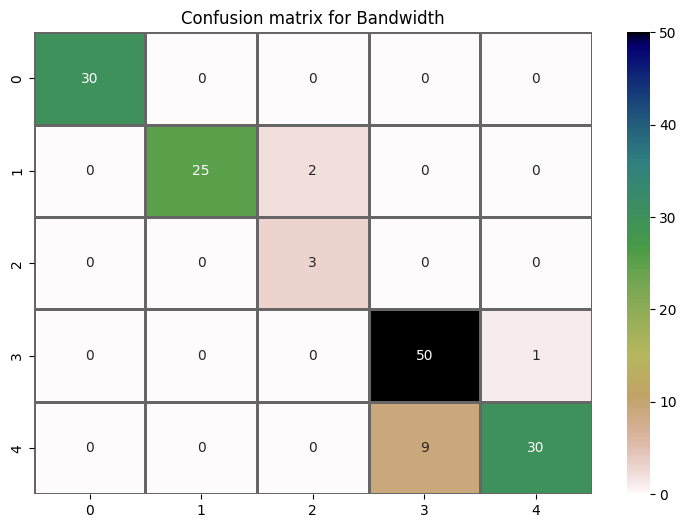

Classification Report for Duration:
              precision    recall  f1-score   support

           0     0.7551    0.8043    0.7789        46
           1     0.9167    0.6286    0.7458        35
           2     0.5000    0.8261    0.6230        23
           3     0.8974    0.7609    0.8235        46

    accuracy                         0.7533       150
   macro avg     0.7673    0.7550    0.7428       150
weighted avg     0.7973    0.7533    0.7610       150



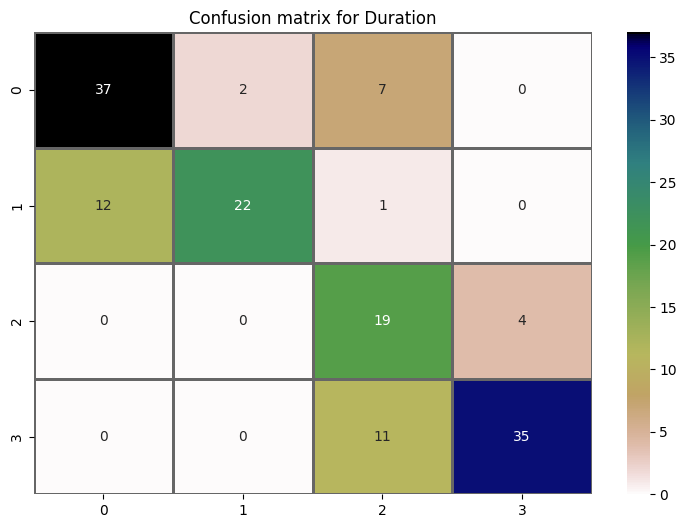

Classification Report for Class:
              precision    recall  f1-score   support

           0     0.7838    0.9667    0.8657        30
           1     0.8276    0.8000    0.8136        30
           2     0.9375    1.0000    0.9677        30
           3     1.0000    1.0000    1.0000        30
           4     1.0000    0.7333    0.8462        30

    accuracy                         0.9000       150
   macro avg     0.9098    0.9000    0.8986       150
weighted avg     0.9098    0.9000    0.8986       150



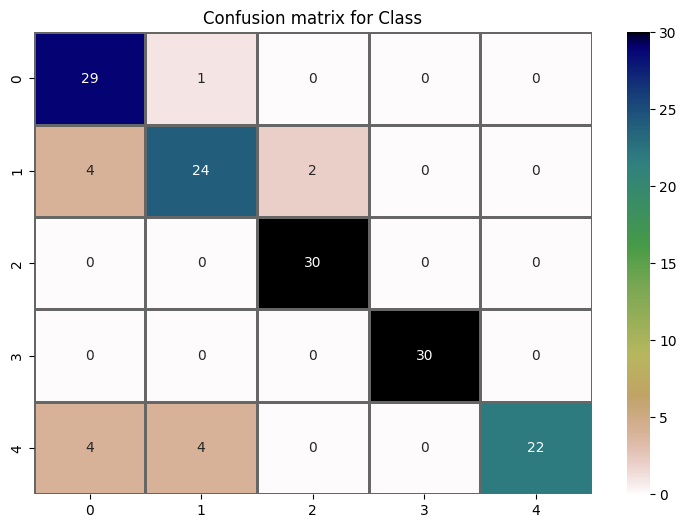

In [3]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy as np

# 对测试数据进行预测
pred = model.predict([testData, testmask])

# 计算每个输出的精度、召回率、F1得分和支持，并绘制混淆矩阵
outputs = ['Bandwidth', 'Duration', 'Class']
true_labels = [Y_test1, Y_test2, Y_test3]
for i in range(3):
    # 获取预测的标签
    predicted = np.argmax(pred[i], axis=1)
    expected = np.argmax(true_labels[i], axis=1)
    
    # 打印指标
    print(f'Classification Report for {outputs[i]}:')
    print(classification_report(expected, predicted, digits=4))

    # 绘制混淆矩阵
    cm = metrics.confusion_matrix(expected, predicted)
    f, ax = plt.subplots(figsize=(9, 6))
    sns.heatmap(cm, annot=True, fmt='0.6g', linewidths=1, cmap='gist_earth_r', linecolor='#666666')
    plt.title(f'Confusion matrix for {outputs[i]}')
    plt.show()